In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from IPython import display
plt.style.use('seaborn')
sns.set()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn import linear_model

In [3]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp

def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp

def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal

def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal

def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves

def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves

def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs

def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw

def get_ftir_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer2/timestamps'][:]
        return timestamps
    
def get_ftir_insertion_spectrum_depths(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        depths = h5_file[f'{insertion_path}/spectrometer2/spectrum_depths'][:]
        return depths

def get_visible_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer1/timestamps'][:]
        return timestamps

def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs

def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def get_visible_insertion_spectrum_depths(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        depths = h5_file[f'{insertion_path}/spectrometer1/spectrum_depths'][:]
        return depths   

def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]
        return insertions

def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions

def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp

def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp

def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal

def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal

def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def compute_3D_distance(x1, y1, z1, x2, y2, z2):
    distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return distance

def calculate_wavenumbers_from_wavelengths(wavelength_vector):
    return 10000000/wavelength_vector

def put_spectrum_in_wavenum_order(spectrum):
    return np.flip(spectrum)

def normalize_depth(depth, depth_min, depth_max):
    return (depth - depth_min) / (depth_max - depth_min)

def get_spectrometer_name(file, session, spectrometer_number):
    with h5py.File(file, 'r') as h5_file:
        name = h5_file[session].attrs[f'spectrometer{spectrometer_number}'][:]
        return name

In [4]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
green_list_df = pd.read_csv('data/Green_misc_insertions_210604.csv')

ftir_min_index = 113
ftir_max_index = 665
ftir_length = ftir_max_index - ftir_min_index

vis_min_index = 0
vis_max_index = 407
vis_length = vis_max_index - vis_min_index

all_absorbances = []
all_depths = []
df = pd.DataFrame()

dates = ['5/27/21', '6/4/21']

for date in dates: 
    bath_df = green_list_df.loc[green_list_df['date'] == date]
    file_name = bath_df.iat[0, 0]
    file = path_name + file_name
    
    for index in bath_df.index.values:
        session = bath_df['session'][index]
        calibration = bath_df['calibration'][index]
        insertion = bath_df['insertion'][index]
        i_unique = bath_df['i_unique'][index]
        stop = date + " " + bath_df['target'][index][-3:]
        cal_path = f'{session}/{calibration}'
        insertion_path = f'{session}/{calibration}/{insertion}'
        vis_waves = get_visible_wavelength_vector(file, cal_path)[vis_min_index:vis_max_index]
        vis_columns = ["%.1f" % wave for wave in vis_waves]
        insertion_df = pd.DataFrame(get_visible_insertion_absorbances(file, insertion_path)[:, vis_min_index:vis_max_index], columns=vis_columns)
        insertion_df['depth'] = get_visible_insertion_spectrum_depths(file, insertion_path)
        insertion_df['session'] = session
        insertion_df['calibration'] = calibration
        insertion_df['insertion'] = insertion
        insertion_df['i_unique'] = i_unique
        insertion_df['stop'] = stop
        insertion_df['use'] = True
        df = pd.concat([df, insertion_df], ignore_index=True)

# to eliminate samples from above the surface
df.loc[(df.depth < 5.0),'use'] = False

# to eliminate vegetation spectra
df.loc[(df['671.2']/df['735.7'] > 1.3), 'use'] = False

    
print(df.shape)

(1125, 414)


In [36]:
df['class'] = 1
df.loc[df['depth'] < 25, 'class'] = 2
df.loc[df['stop'] == '6/4/21 #10', 'class'] = 4
df.loc[df['stop'] == '6/4/21 #9', 'class'] = 4
df.loc[df['stop'] == '6/4/21 #8', 'class'] = 3
df.loc[df['stop'] == '5/27/21  #6', 'class'] = 3


    

In [37]:
# creates a dataframe containing only the "use" rows
df_use = df.loc[df['use']].copy()
print(df_use.shape)

(1006, 415)


In [38]:
X = df_use.iloc[:, :-8].copy()
X.shape

(1006, 407)

In [39]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

In [40]:
np.cumsum(pca.explained_variance_ratio_)

array([0.89988971, 0.94243191, 0.95957176, 0.96977648, 0.97291937,
       0.97383351, 0.97463782, 0.97522885, 0.97579683, 0.97624448,
       0.97667727, 0.97708686, 0.97748507, 0.97786993, 0.97825112,
       0.97861031, 0.97896261, 0.97930087, 0.97963293, 0.97995526,
       0.98026914, 0.98056886, 0.98086448, 0.98115879, 0.98144897,
       0.98173018, 0.98200091, 0.98226391, 0.98252322, 0.98277862,
       0.98303036, 0.98327901, 0.98352097, 0.98375775, 0.98398701,
       0.98421349, 0.98443513, 0.98465461, 0.98486722, 0.98507548,
       0.98528047, 0.98547808, 0.98567053, 0.98586166, 0.98604691,
       0.98622728, 0.98640378, 0.98657946, 0.98675073, 0.98691842])

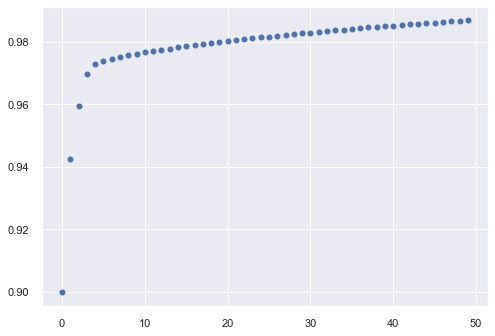

In [41]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'bo')
plt.show()
plt.close()

In [42]:
X_pca_df = pd.DataFrame(X_pca)

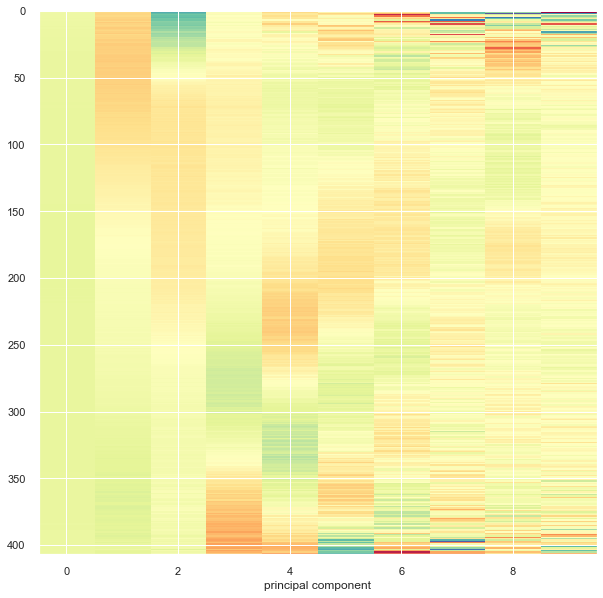

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(pca.components_[:10].T, cmap="Spectral", vmin=-0.3, vmax=0.3, aspect='auto',
          interpolation='none')
# plt.yticks(range(len(X.columns)), X.columns)
plt.xlabel("principal component")
plt.show()
plt.close()

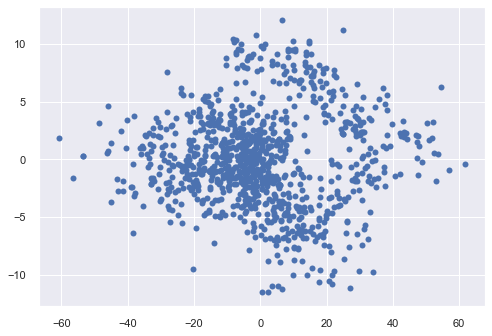

In [44]:
fig, ax = plt.subplots()
ax.plot(X_pca_df[0], X_pca_df[1], 'o')
plt.show()
plt.close()

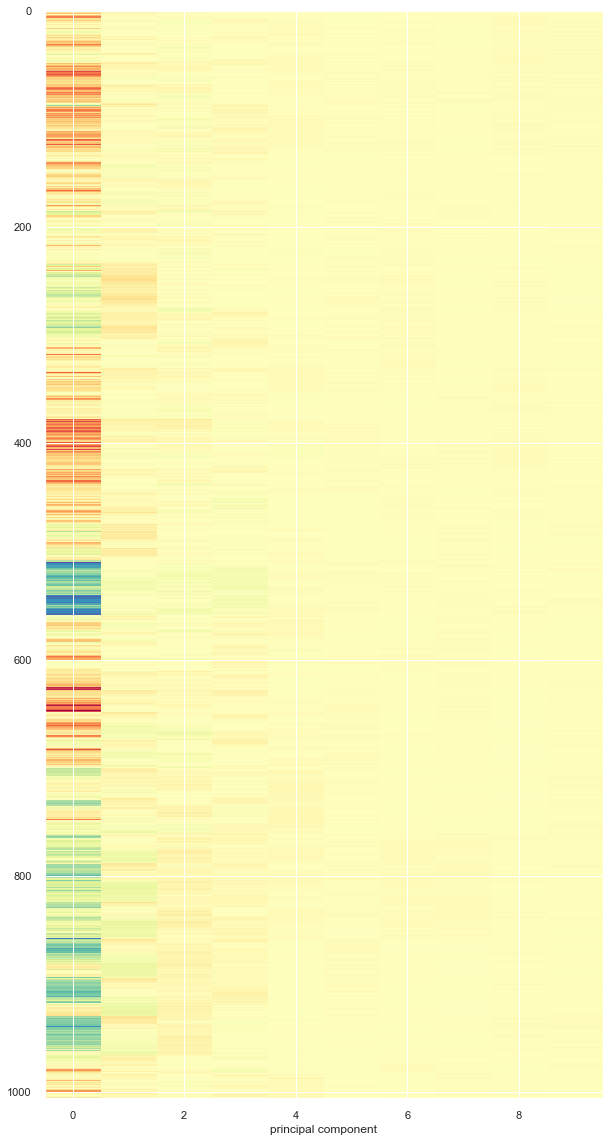

In [45]:
fig, ax = plt.subplots(figsize=(10, 20))
plt.imshow(X_pca[:, :10], cmap="Spectral", aspect='auto',
          interpolation='none')
# plt.yticks(range(len(X.columns)), X.columns)
plt.xlabel("principal component")
plt.show()
plt.close()

In [46]:
df_info = df_use.iloc[:, -8:].copy().reset_index()

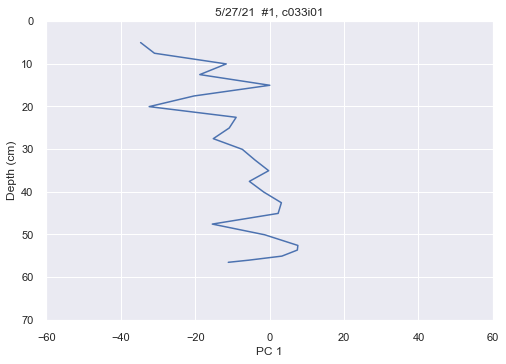

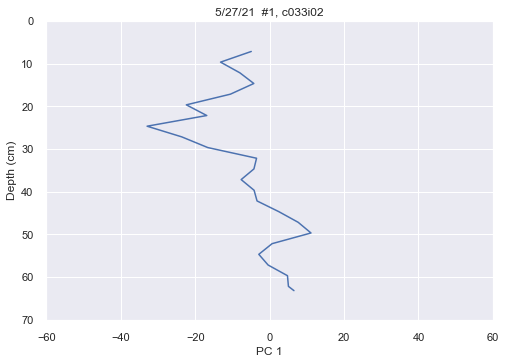

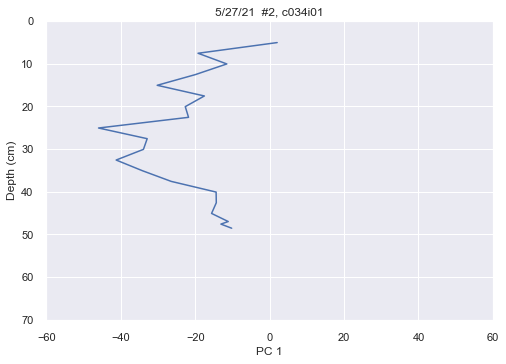

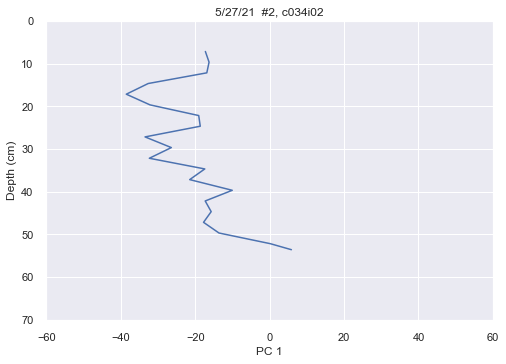

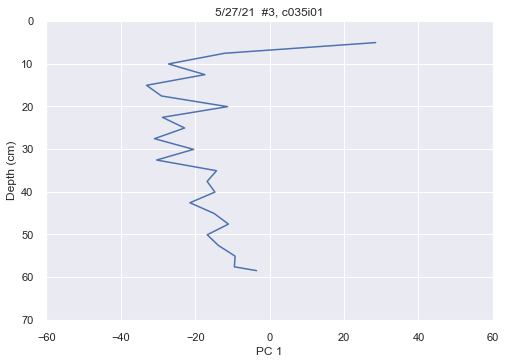

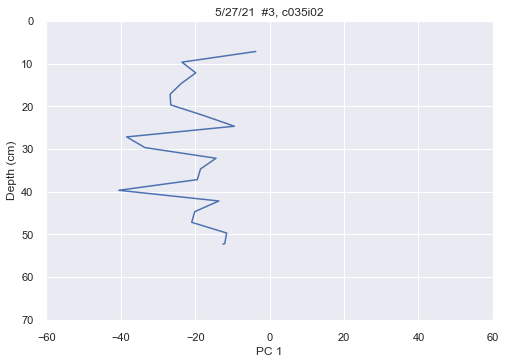

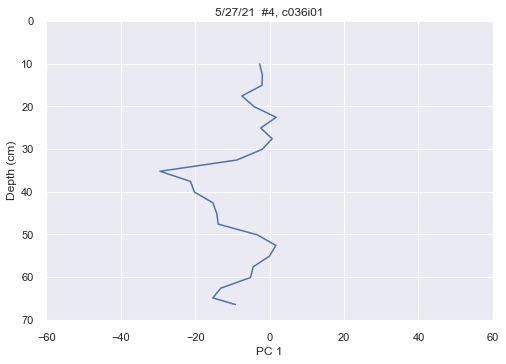

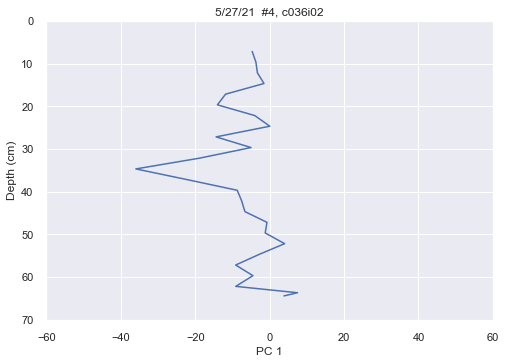

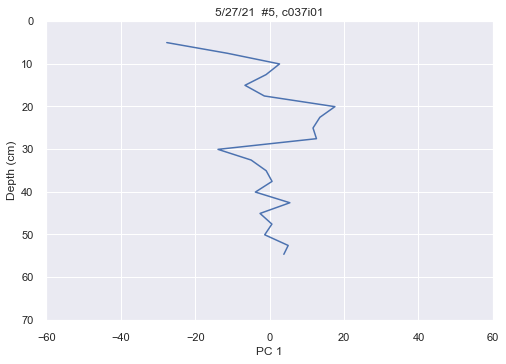

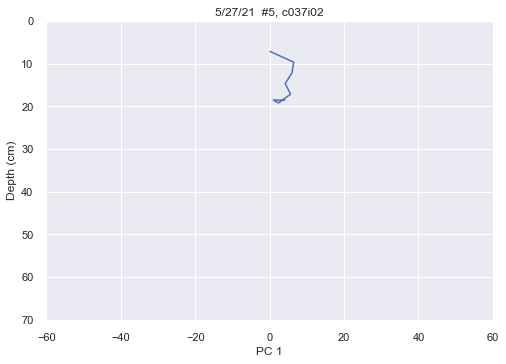

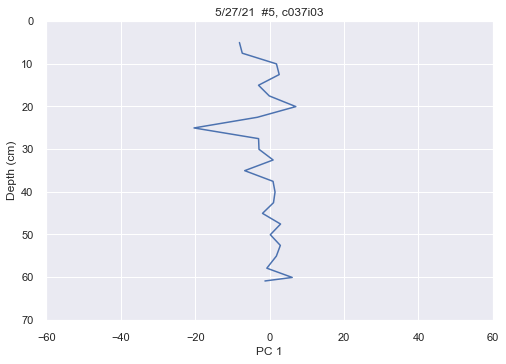

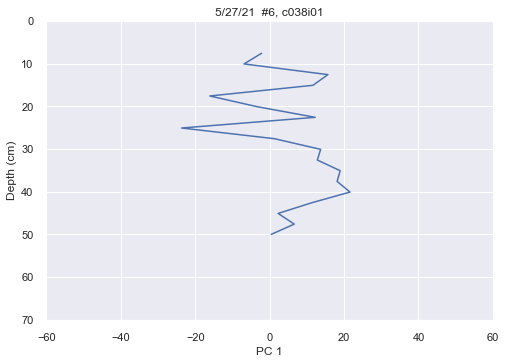

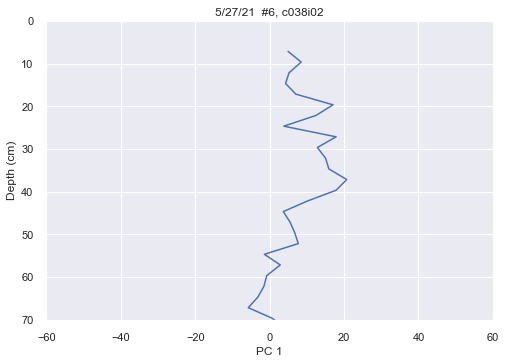

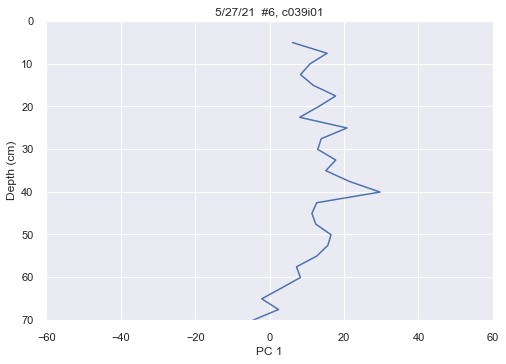

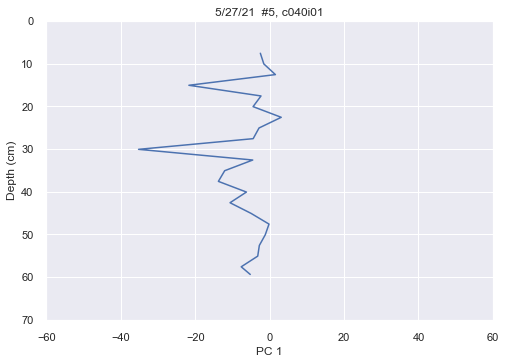

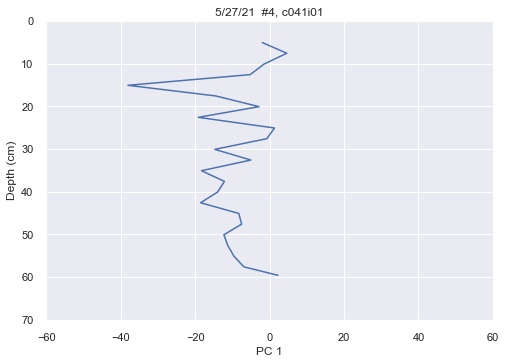

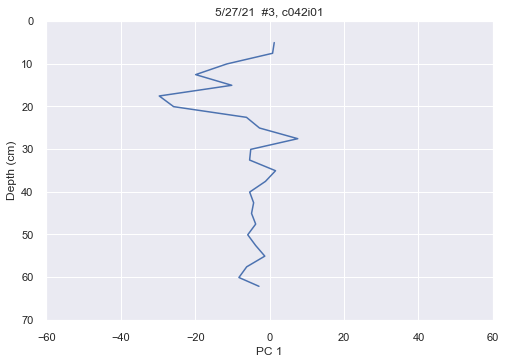

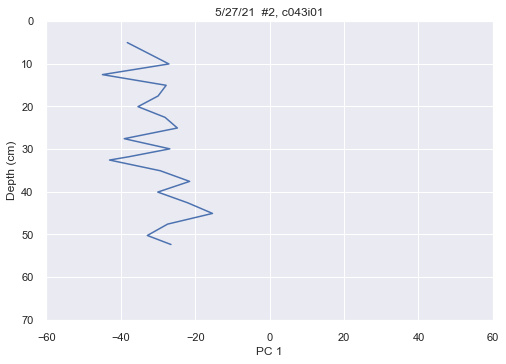

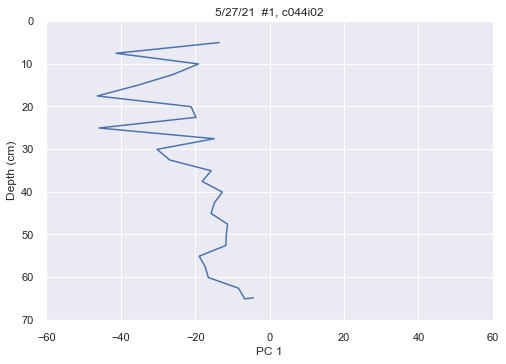

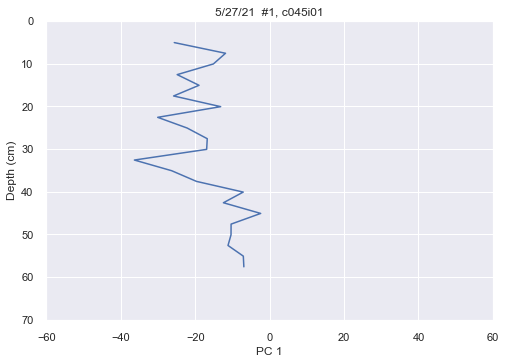

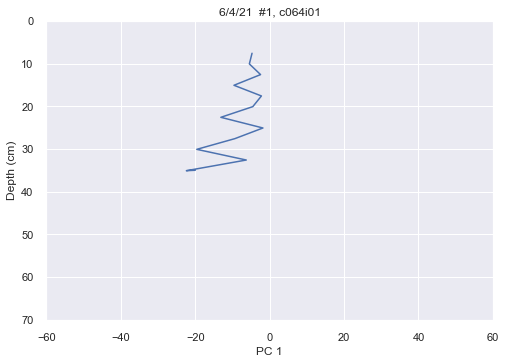

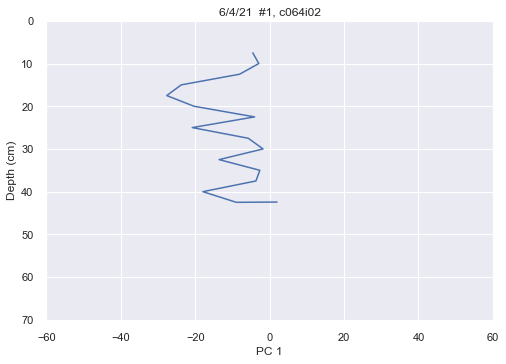

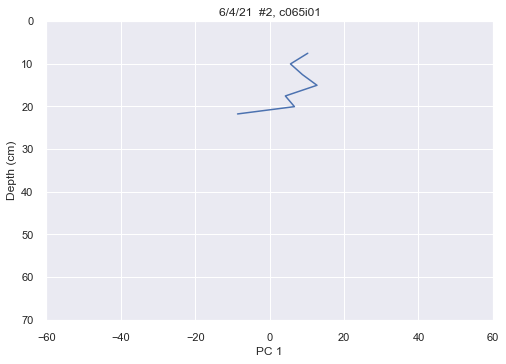

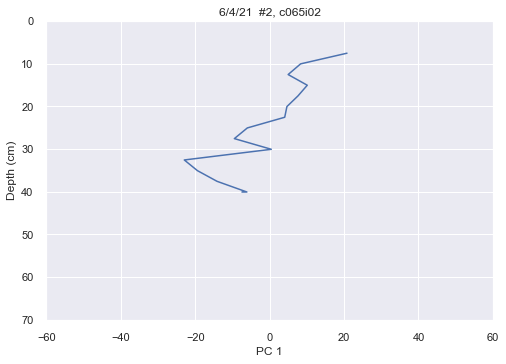

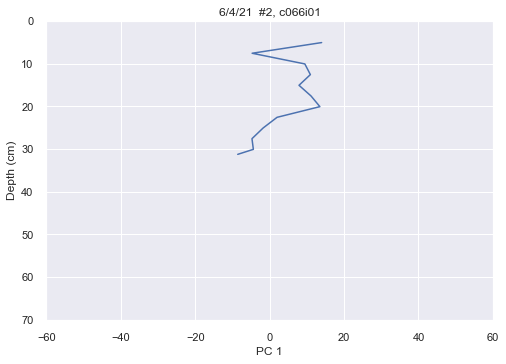

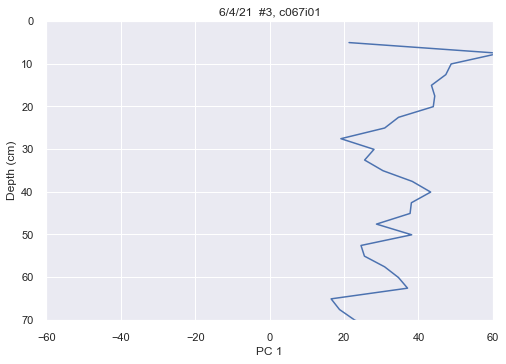

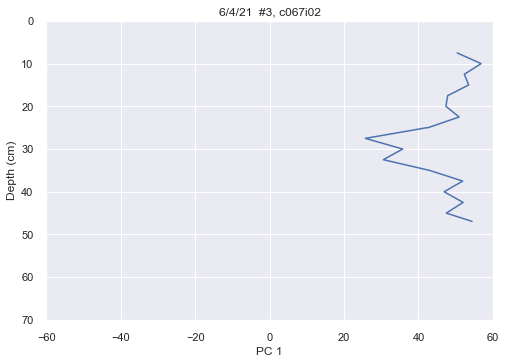

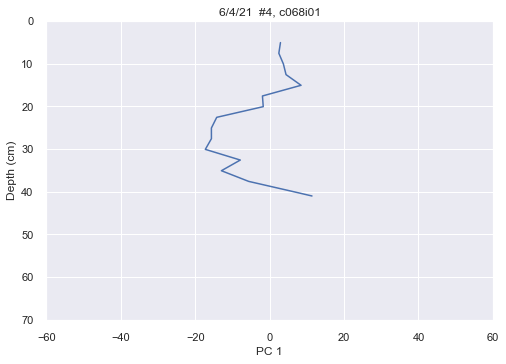

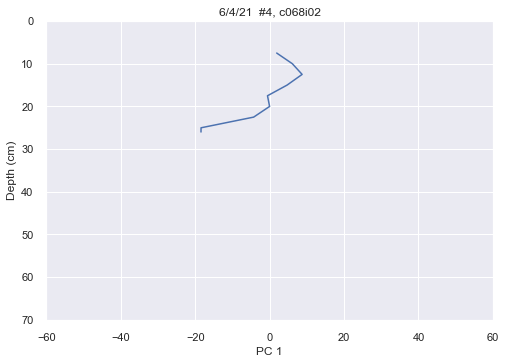

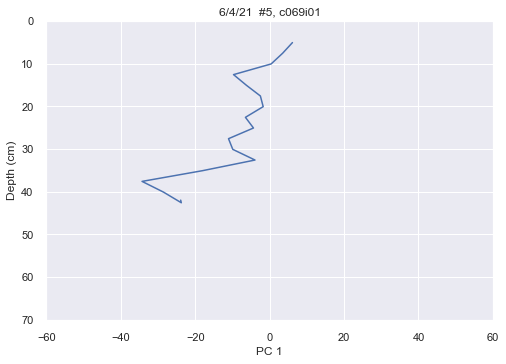

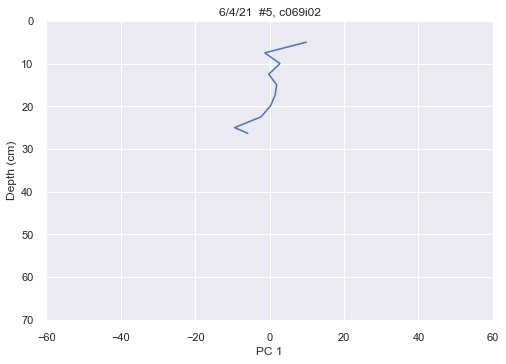

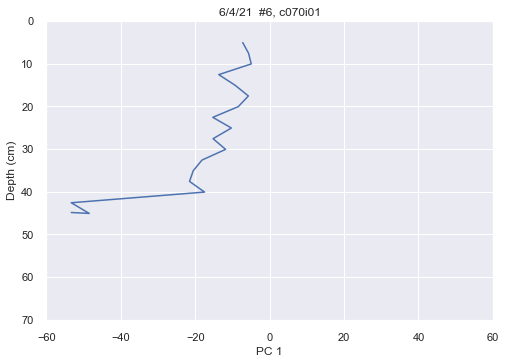

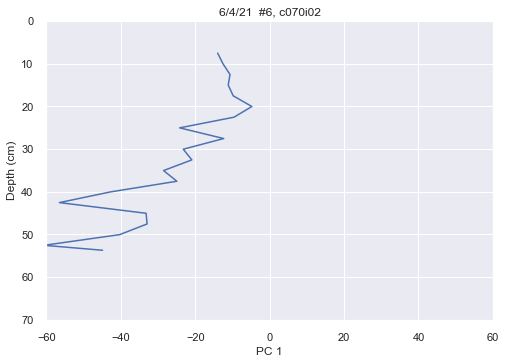

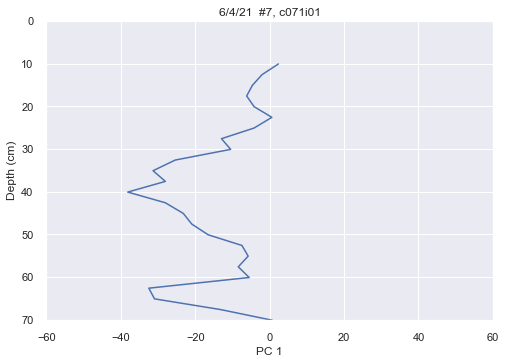

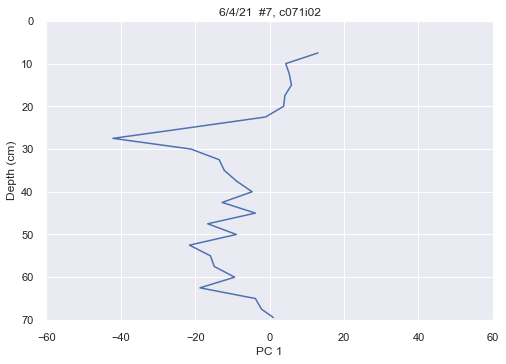

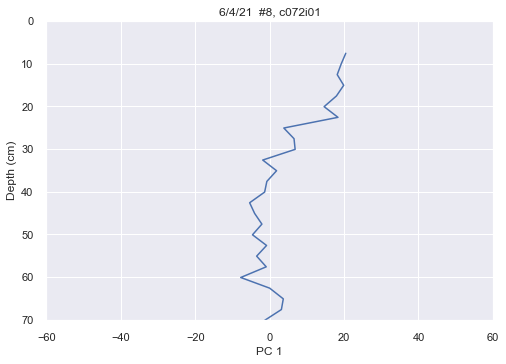

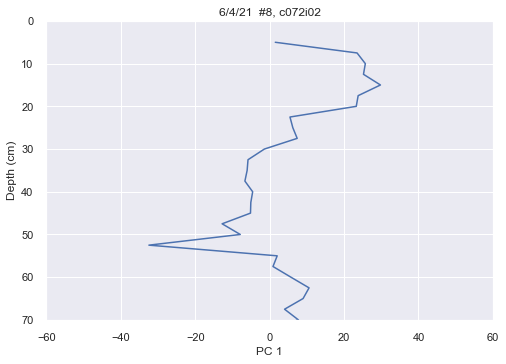

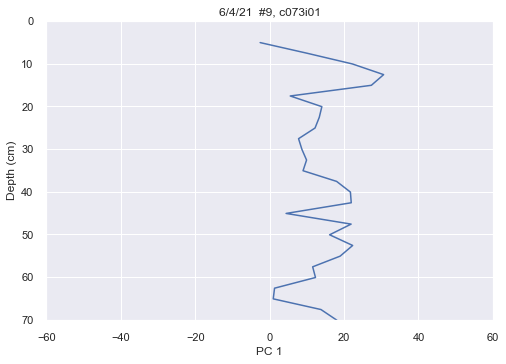

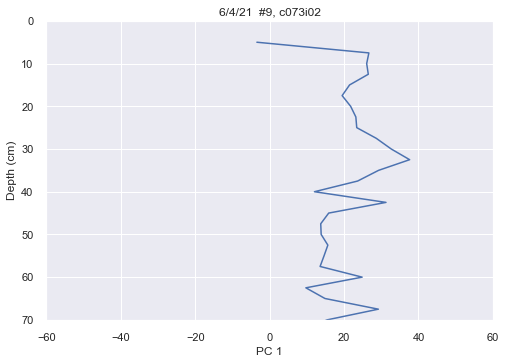

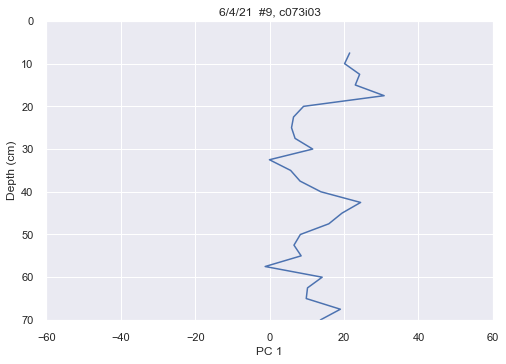

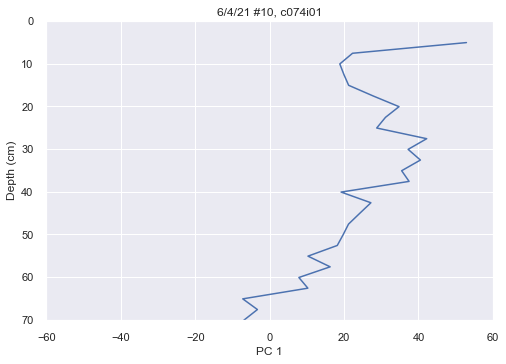

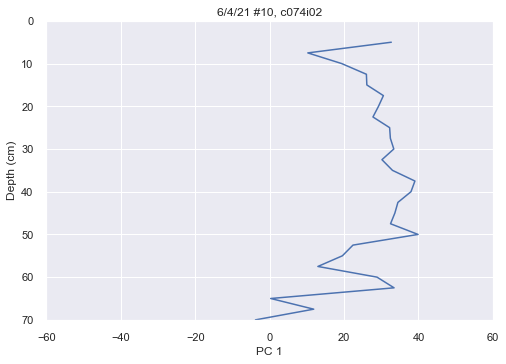

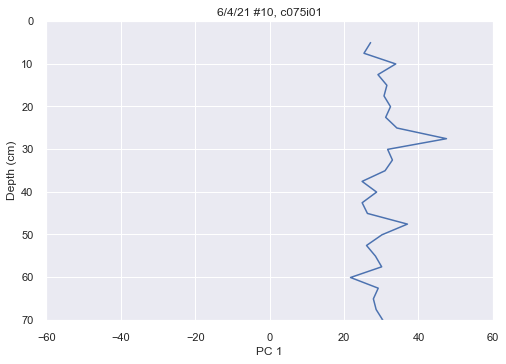

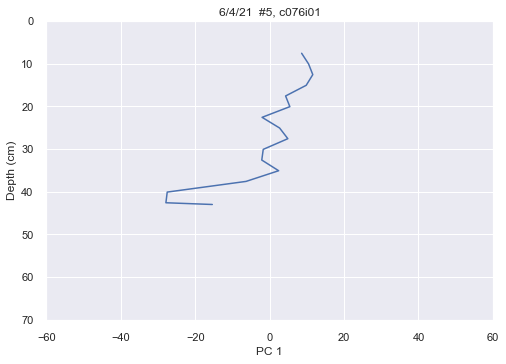

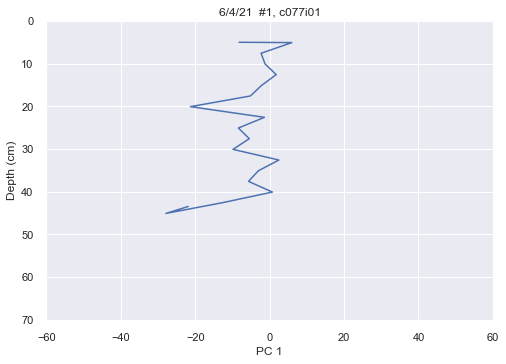

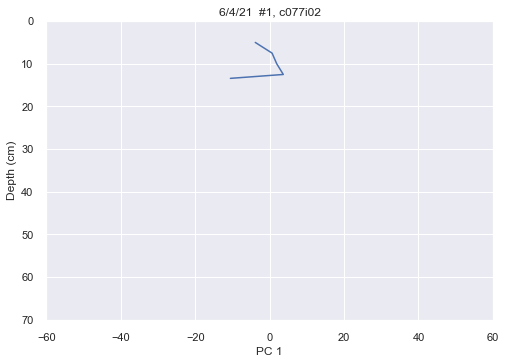

In [48]:
component = 1
for insertion in df_info['i_unique'].unique():
    insertion_df_info = df_info.loc[df_info['i_unique'] == insertion]
    insertion_components = X_pca_df.loc[df_info['i_unique'] == insertion]
    fig, ax = plt.subplots()
    ax.set_title(f"{insertion_df_info.iat[0, -3]}, {insertion}")
    ax.set_ylim(70, 0)
    ax.set_xlim(-60, 60)
    ax.set_ylabel("Depth (cm)")
    ax.set_xlabel(f"PC {component}")
    ax.plot(insertion_components.iloc[:, component - 1], insertion_df_info['depth'])
    plt.show()
    plt.close()

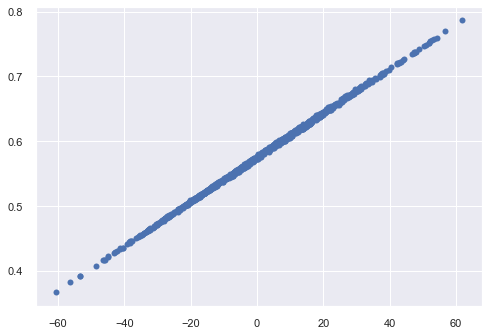

In [54]:
plt.plot(X_pca_df[0], df_use.iloc[:, :-8].mean(axis=1), 'o')

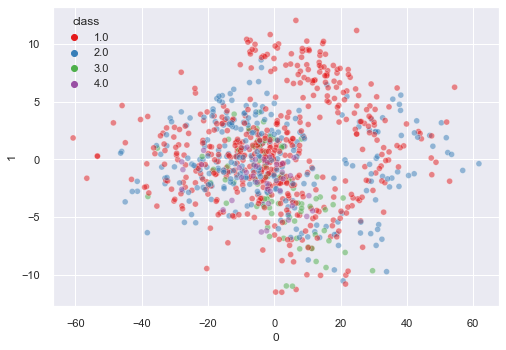

In [59]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_pca_df[0], y=X_pca_df[1], 
                hue=df_use['class'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()


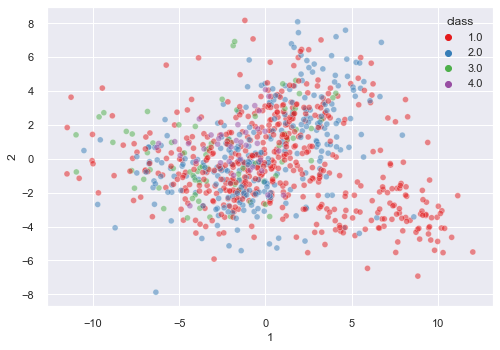

In [60]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_pca_df[1], y=X_pca_df[2], 
                hue=df_use['class'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()

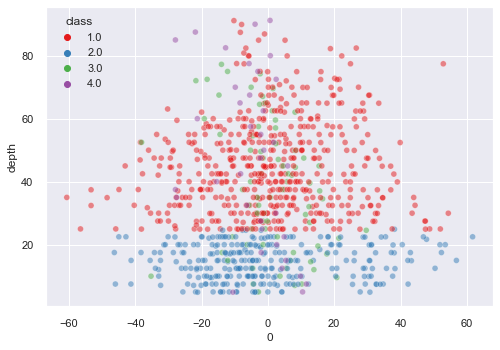

In [62]:
fig, ax = plt.subplots()
sns.scatterplot(x=X_pca_df[0], y=df_use['depth'], 
                hue=df_use['class'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()

In [63]:
X_pca_df.groupby(df_use['class']).mean()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
class,,,,,,,,,,,,,,,,,,,,,
1.0,0.780391,0.868098,-0.331751,-0.239488,0.134214,0.040907,-0.015367,0.019958,-0.005704,-0.060265,...,0.016820,-0.014927,0.014278,0.011817,-0.019151,0.003930,-0.008460,0.009287,-0.006928,0.009048
2.0,-0.904151,-0.149321,0.414396,0.355133,-0.105824,-0.078578,0.066394,-0.048904,0.020622,0.043590,...,-0.020156,-0.006530,-0.014166,0.005462,-0.004468,-0.002886,0.000110,-0.011600,0.009869,-0.005916
3.0,0.510853,-2.798936,0.396424,-0.500080,-0.132371,-0.134747,-0.511303,0.175177,-0.109580,0.221484,...,-0.052923,0.026816,-0.011227,-0.023022,0.097748,-0.011550,0.039700,0.019540,0.037846,0.006434
4.0,-4.633421,-1.972081,0.716976,0.424120,-0.191388,0.534276,0.535293,-0.138421,0.158843,0.087115,...,0.087622,0.106522,-0.073043,-0.108479,0.050383,0.031158,-0.076324,-0.079780,-0.025299,-0.108301


<AxesSubplot:xlabel='0', ylabel='Density'>

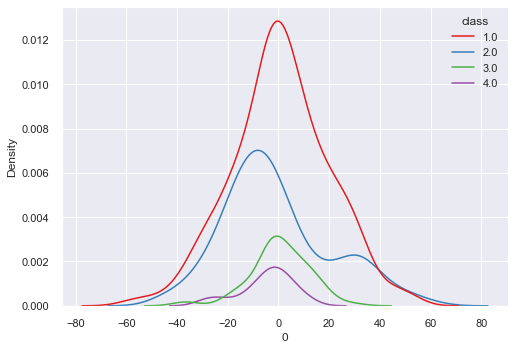

In [66]:
sns.kdeplot(x=X_pca_df[0], hue=df_use['class'], palette='Set1')

<AxesSubplot:xlabel='1', ylabel='Density'>

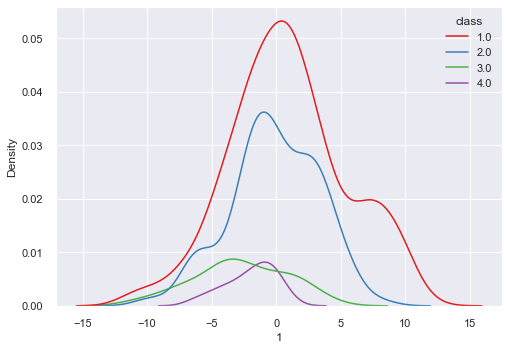

In [67]:
sns.kdeplot(x=X_pca_df[1], hue=df_use['class'], palette='Set1')

<AxesSubplot:xlabel='2', ylabel='Density'>

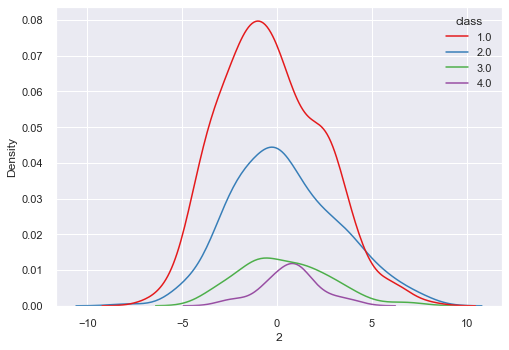

In [68]:
sns.kdeplot(x=X_pca_df[2], hue=df_use['class'], palette='Set1')

<AxesSubplot:xlabel='stop', ylabel='0'>

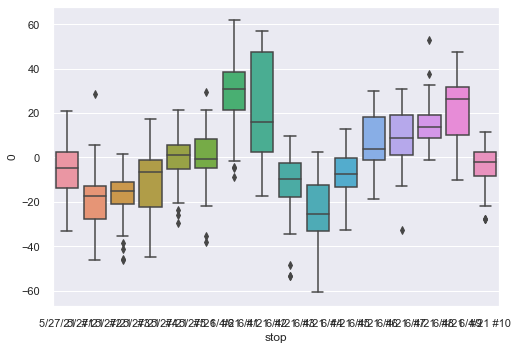

In [71]:
sns.boxplot(x=df_use['stop'], y=X_pca_df[0])

<AxesSubplot:xlabel='stop', ylabel='1'>

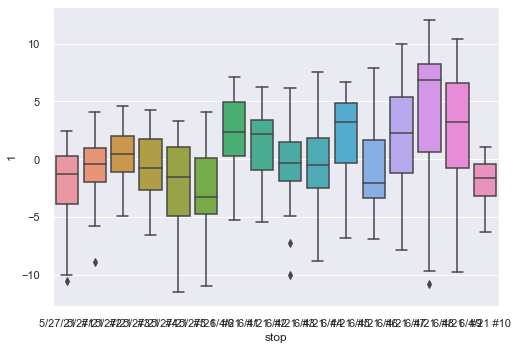

In [72]:
sns.boxplot(x=df_use['stop'], y=X_pca_df[1])

<AxesSubplot:xlabel='stop', ylabel='2'>

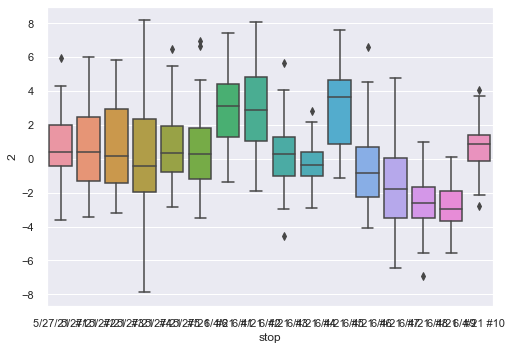

In [73]:
sns.boxplot(x=df_use['stop'], y=X_pca_df[2])